In [1]:
from typing import TypedDict
import os 
from dotenv import load_dotenv 
from langchain_openai import ChatOpenAI

In [2]:
load_dotenv() 
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [3]:
from typing import Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage, SystemMessage

class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process" 
    )

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

router = llm.with_structured_output(Route)


In [4]:
class State(TypedDict):
    input: str 
    decision: str 
    output: str

In [5]:
def llm1_call(state: State) -> State:
    """Write a story""" 
    result = llm.invoke(state["input"]) 
    return {"output": result.content} 

def llm2_call(state: State) -> State:
    """Write a joke""" 
    result = llm.invoke(state["input"]) 
    return {"output": result.content} 

def llm3_call(state: State) -> State:
    """Write a poem"""
    result = llm.invoke(state["input"]) 
    return {"output": result.content} 

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage
def llm_with_router(state: State) -> State:
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(
                content = "Route the input to story, joke or poem based on the user's request" 
            ), 
            HumanMessage(content = state["input"])
        ]
    )
    return {"decision": decision.step}

def route_decision(state: State):
    if state["decision"] == "story":
        return "llm1_call"
    elif state["decision"] == "joke":
        return "llm2_call" 
    elif state["decision"] == "poem":
        return "llm3_call"

In [13]:
from langgraph.graph import StateGraph, START, END 
router_builder = StateGraph(State)
router_builder.add_node("llm1_call", llm1_call)
router_builder.add_node("llm2_call", llm2_call)
router_builder.add_node("llm3_call", llm3_call)
router_builder.add_node("llm_with_router", llm_with_router) 

# Add edges 
router_builder.add_edge(START, "llm_with_router") 
router_builder.add_conditional_edges(
    "llm_with_router", 
    route_decision, 
    {
        "llm1_call": "llm1_call", 
        "llm2_call": "llm2_call", 
        "llm3_call": "llm3_call",
    }
)
router_builder.add_edge("llm1_call", END) 
router_builder.add_edge("llm2_call", END) 
router_builder.add_edge("llm3_call", END)

router_workflow = router_builder.compile() 


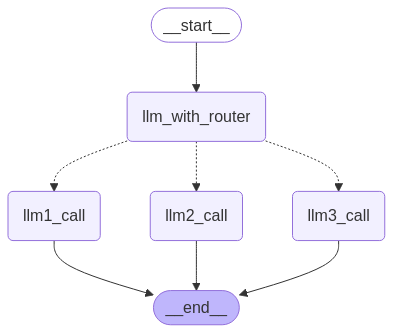

In [14]:
from IPython.display import Image, display 
display(Image(router_workflow.get_graph().draw_mermaid_png())) 


In [15]:
router_workflow.invoke({"input": "Write a story about cats"})

{'input': 'Write a story about cats',
 'decision': 'story',
 'output': 'Once upon a time in a quaint little village nestled between rolling hills and lush green fields, there was a peculiar phenomenon: every cat in the village had a secret. By day, they lounged in sunbeams, chased butterflies, and napped in cozy corners. But by night, they transformed into the Guardians of Whiskerwood, a mystical realm that existed just beyond the village’s borders.\n\nThe leader of the Guardians was a wise old tabby named Sir Whiskers. With his grizzled fur and piercing green eyes, he commanded respect from all the cats in the village. Sir Whiskers had a special mission: to protect the enchanted forest of Whiskerwood from the mischievous spirits that sought to disrupt its harmony.\n\nOne evening, as the sun dipped below the horizon and painted the sky in hues of orange and purple, the cats gathered at the ancient oak tree at the edge of the village. It was time for their nightly meeting. Sir Whiskers 